# Modelling Neural Circuits

Based on Rosenbaum's book.

In [4]:
from dynamics import dynamics_solve

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (6, 4)

# Modeling Single Neurons

The $\emph{membrane potential}$ is the electric potential difference measured in the neuron with respect to the intercellular space, denoted as $V$. Normally, this is around -70 mV. 

When ions flow into the neuron through ion channels, the membrane potential changes. Above the $\emph{threshold potential}$ around $V\sim -55$ mV, the membrane potential spikes to around $0-10$ mV that lasts about $1-2$ ms. 

Spikes propagate down the neuron's axon, where they activate synapses. The synpases open ion channels on the postsynaptic neuron's membrane, causing a brief pulse of current (hence the postsynaptic membrane potential). 


## The Leaky Integrator Model

The membrane potential can be modeled as a leaky capacitor circuit $$C_m \frac{dV}{dt} = I(t)$$ where $V(t)$ is the membrane potential, $I(t)$ is the current across the membrane (into as positive), and $C_m$ is the (effective) capacitance of the membrane. (Note that $I(t)$ represents the average current per-unit area in reality, but we may interpret it as a single current.)

For most cortical neurons, the ion channels and pumps can be effectively approximated by a single current called the $\emph{leak current}$. 

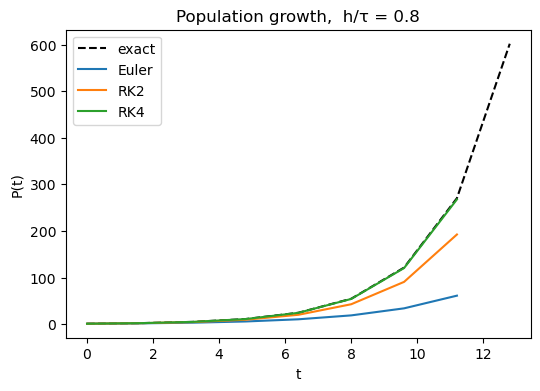

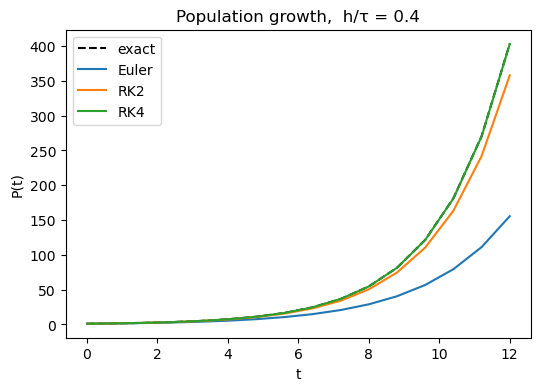

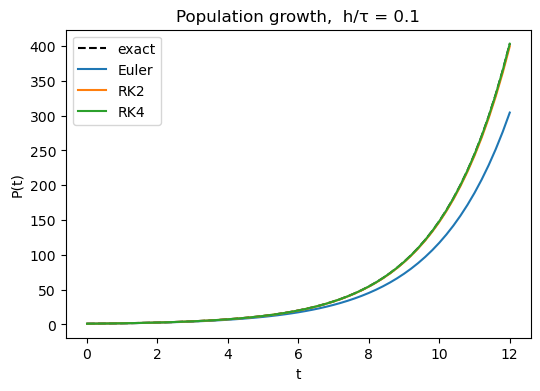

In [3]:
# Parameters
B, D = 0.6, 0.1           # birth & death rates  →  net r = 0.5
tau = 1/abs(B-D)          # natural time-scale
P0  = 1.0
t0, T_end = 0.0, 6*tau    # simulate for six e-folding times

# Right-hand side
f = lambda t, P: (B - D) * P
exact = lambda t: P0*np.exp((B-D)*t)

# Step sizes to try
hs = [0.8*tau, 0.4*tau, 0.1*tau]
methods = ["Euler", "RK2", "RK4"]

for h in hs:
    t_exact = np.arange(t0, T_end+h, h)
    plt.figure()
    plt.plot(t_exact, exact(t_exact), "k--", label="exact")
    for m in methods:
        T, P = dynamics_solve(f, D=1, t_0=t0, s_0=P0, h=h,
                              N=int((T_end-t0)/h), method=m)
        plt.plot(T, P, label=m)
    plt.title(f"Population growth,  h/τ = {h/tau:.2g}")
    plt.xlabel("t"); plt.ylabel("P(t)"); plt.legend(); plt.show()